# Задание 1: Сравнение CNN и полносвязных сетей (40 баллов)


## 1.1 Сравнение на MNIST (20 баллов)
 Сравните производительность на MNIST:
 - Полносвязная сеть (3-4 слоя)
 - Простая CNN (2-3 conv слоя)
 - CNN с Residual Block
 
 Для каждого варианта:
 - Обучите модель с одинаковыми гиперпараметрами
 - Сравните точность на train и test множествах
 - Измерьте время обучения и инференса
 - Визуализируйте кривые обучения
 - Проанализируйте количество параметров

### Создадим даталоадеры на основе датасетов MNIST/CIFAR

In [443]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]

def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


# Создадим переменные для последующей быстрой передачи
mnist_train, mnist_test = get_mnist_loaders()

### Создаем классы нейронных сетей

In [261]:
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64*7*7, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class SimpleResNet(nn.Module):
    def __init__(self, in_channels=1,  num_classes=10):
        super().__init__()
                # Residual блок
        self.layer1 = ResidualBlock(in_channels, 64, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(2, 2)    # 28x28 --> 14x14
        self.fc = nn.Linear(64*14*14, num_classes)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)               
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)          
        return x

class SimpleLinear(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.batchNorm1 = nn.BatchNorm1d(64)
        self.batchNorm2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Выравниваем в вектор (Flatten)
        x = F.relu(self.batchNorm1(self.fc1(x)))
        x = F.relu(self.batchNorm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


### Функции для обучения  

In [510]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def run_epoch(model, data_loader, criterion, optimizer=None, device='cuda:0', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()
    
    total_loss = 0
    correct = 0
    total = 0
    
    # Переносим модель на устройство 
    model.to(device)
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        if not is_test and optimizer is not None:
            optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        
        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return total_loss / len(data_loader), correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cuda:0'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        # print(f'Epoch {epoch+1}/{epochs}:')
        # print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        # print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        # print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    } 

In [266]:
# Сравните производительность на MNIST:
# - Полносвязная сеть (3-4 слоя)
fc_model = SimpleLinear(in_channels=28*28, num_classes=10)
# - Простая CNN (2-3 conv слоя)
cnn_model = SimpleCNN(input_channels=1, num_classes=10)
# - CNN с Residual Block
residual_model = SimpleResNet(in_channels=1, num_classes=10)


### Обучение моделей

In [269]:
print('CNN')
cnn_metrics = train_model(cnn_model, mnist_train, mnist_test)
print('FCN')
fc_metrics = train_model(fc_model, mnist_train, mnist_test)
print('ResNet')
residual_metrics = train_model(residual_model, mnist_train, mnist_test)

CNN


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:14<00:00, 25.49s/it]


FCN


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:28<00:00, 20.81s/it]


ResNet


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:33<00:00, 27.32s/it]


In [275]:
# Сохраним метрики
torch.save(cnn_metrics, 'laba4/cnn_metrics.pt')
torch.save(fc_metrics, 'laba4/fc_metrics.pt')
torch.save(residual_metrics, 'laba4/residual_metrics.pt')

### Для каждого варианта:
 - Обучите модель с одинаковыми гиперпараметрами
> Done

###  Сравните точность на train и test множествах


In [278]:
import torch
import matplotlib.pyplot as plt


def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.grid(True)
    ax1.legend()
    
    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    

### Метрики CNN 

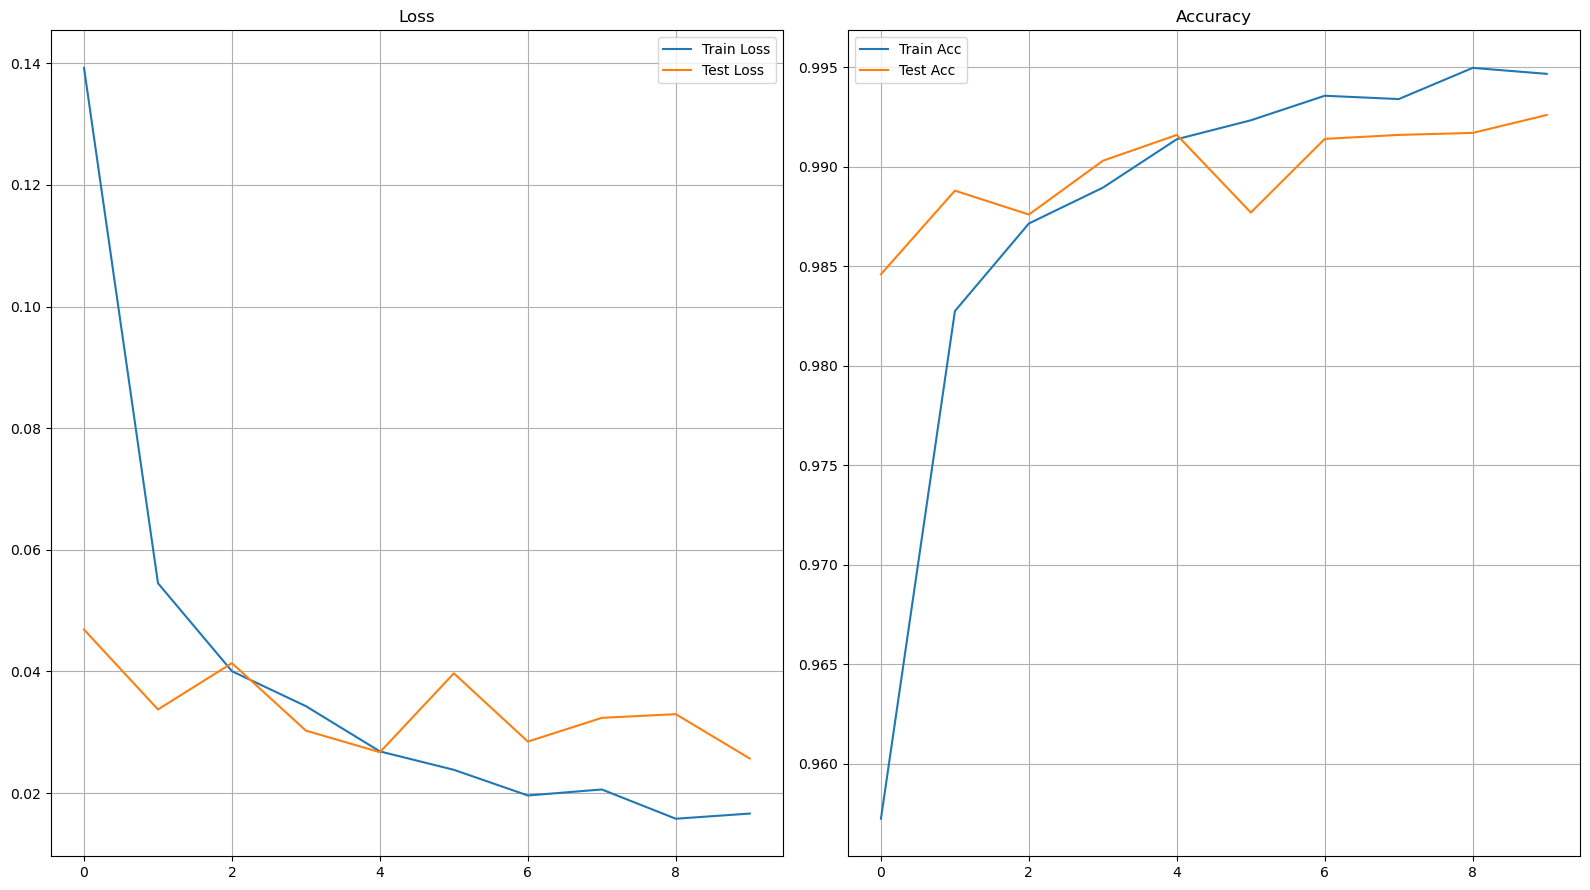

In [280]:
plot_training_history(cnn_metrics)

### Метрики FCN

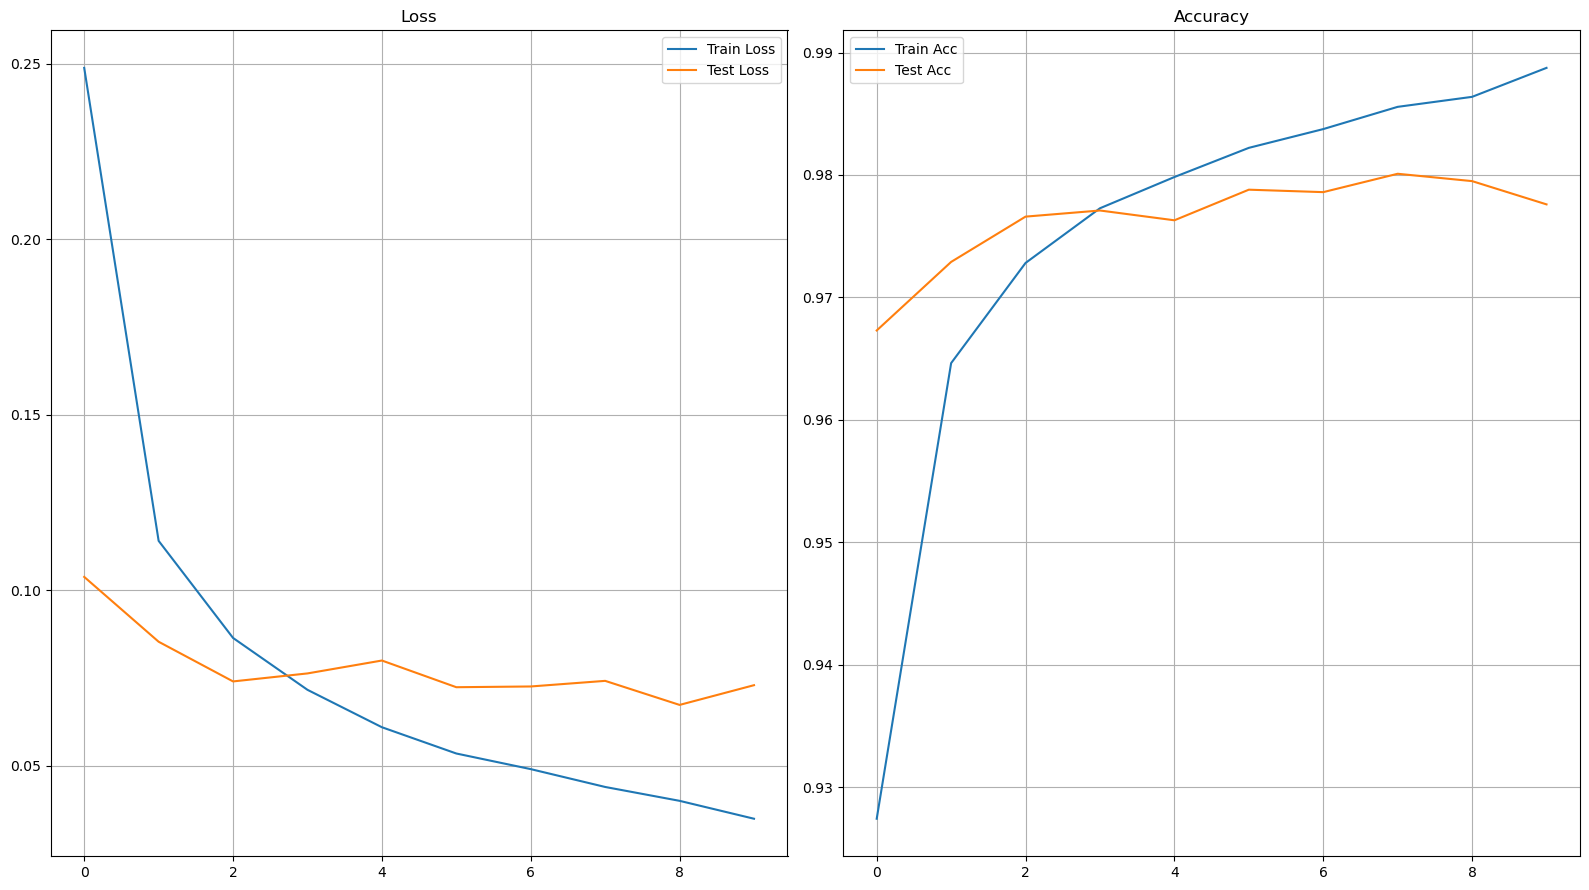

In [283]:
plot_training_history(fc_metrics)

### Метрики ResNet

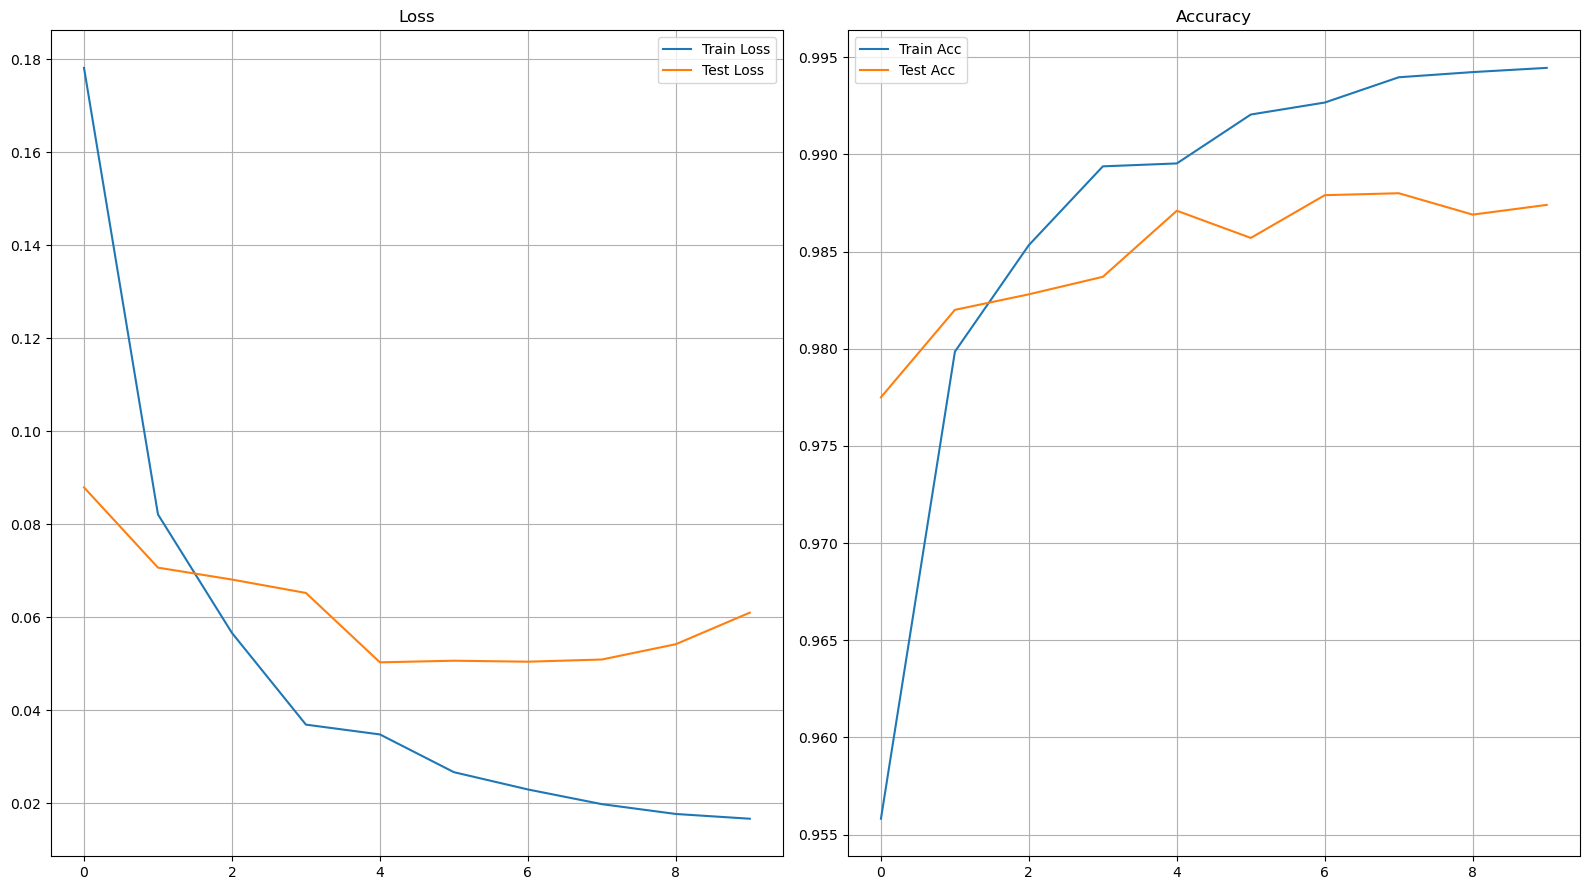

In [285]:
plot_training_history(residual_metrics)

### Измерьте время обучения и инференса
- Время обучения для каждой из моделей было:
   > CNN:    4:14 min | 25 sec/epoch
   > 
   > FCN:    3:28 min | 21 sec/epoch
   >
   > ResNet: 4:33 min | 27 sec/epoch
### Инференс :

In [329]:
# Функция подсчета времени для GPU (основа взята с первой ДЗ)
def inference(model, device='cuda:0'):
    model.eval()
    model = model.to(device)
    
    # Инициализируем cuda Events и активируем счетчик времени
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    
    # Проходимся во test_mnist_batch
    for batch_idx, (data, target) in enumerate(mnist_test):
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        
    end.record()
    torch.cuda.synchronize()  # Ждем пока все ядра закончат работать 
    
    # Делим общее время на количество изображений чтобы узнать время обработки 1 изображения 
    total_time = start.elapsed_time(end) / (len(mnist_test)  * 64)  
    return total_time

cnn_infer, fcn_infer, resnet_infer = inference(cnn_model), inference(fc_model), inference(residual_model)
print(f'CNN infer is {cnn_infer:.2f} ms ({1000/cnn_infer:.2f} fps)')
print(f'FCN infer is {fcn_infer:.2f} ms ({1000/fcn_infer:.2f} fps)')
print(f'ResNet infer is {resnet_infer:.2f} ms ({1000/resnet_infer:.2f} fps)')

CNN infer is 0.18 ms (5524.14 fps)
FCN infer is 0.19 ms (5397.53 fps)
ResNet infer is 0.20 ms (5128.20 fps)


### Визуализируйте кривые обучения
 Создадим AUC-ROC

In [431]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def auc_roc(model, test_loader, device='cuda:0'):
    model.eval()  # Переводим модель в режим оценки
    model = model.to(device)
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Преобразуем логиты в вероятности
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())
    
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    n_classes = all_probs.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Класс {0} (AUC = {1:0})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC кривая для каждого класса')
    plt.legend(loc="lower right")
    plt.show()



#### AUC ROC

Абсолютно все модели по всем классам в mnist_test имеют площадь под AUC-ROC в районе **0.9999+**

CNN


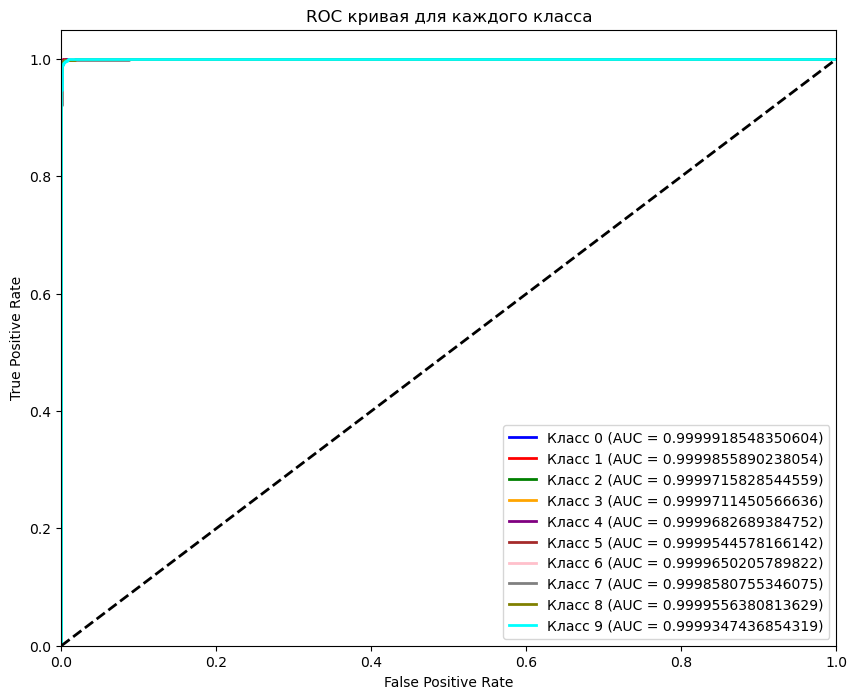

FCN


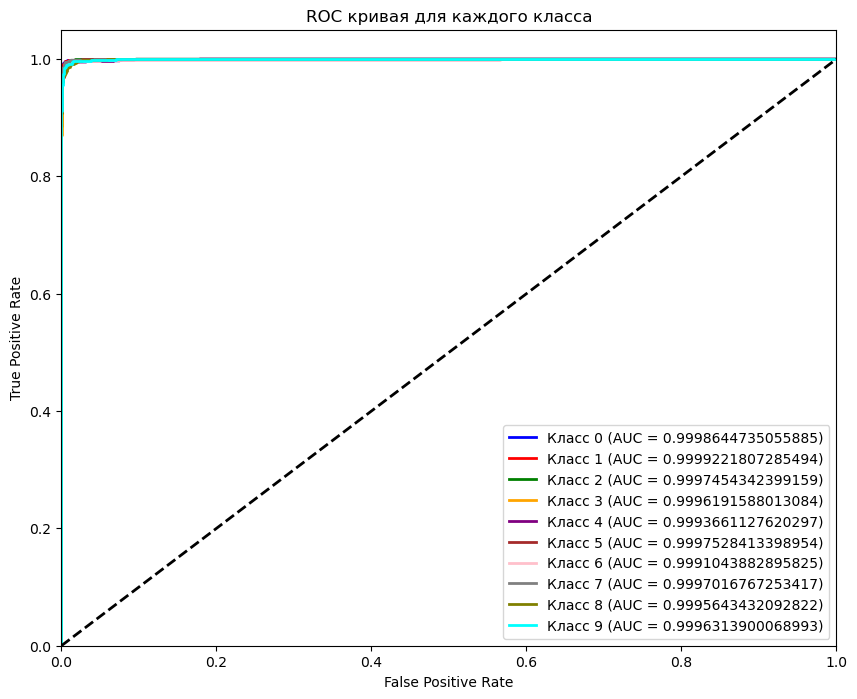

ResNet


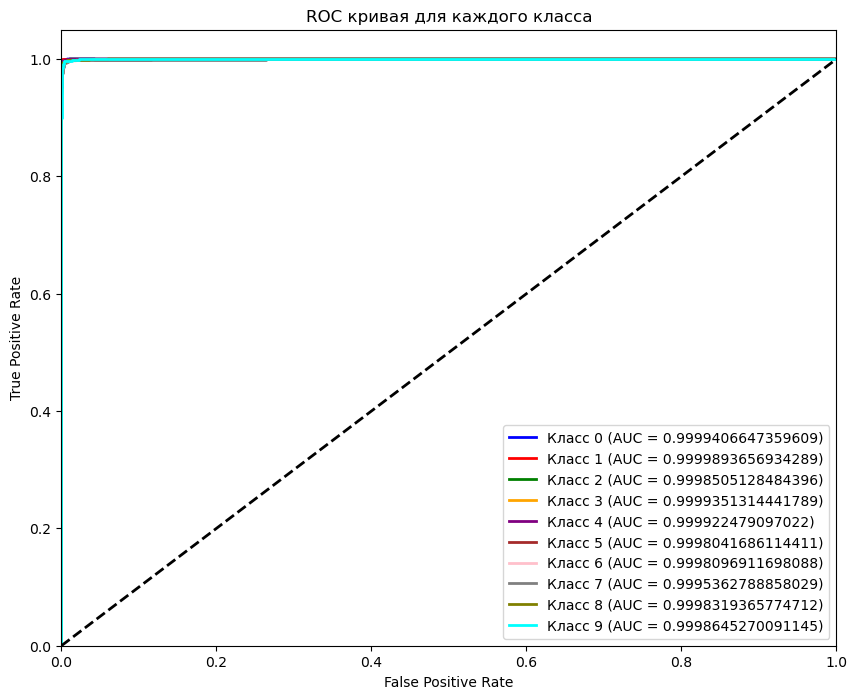

In [433]:
print('CNN')
auc_roc(cnn_model, mnist_test)
print('FCN')
auc_roc(fc_model, mnist_test)
print('ResNet')
auc_roc(residual_model, mnist_test)

## 1.2 Сравнение на CIFAR-10 (20 баллов)


In [480]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class CIFARDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.CIFAR10(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]

def get_cifar_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_dataset = CIFARDataset(train=True, transform=transform)
    test_dataset = CIFARDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader 


# Создадим переменные для последующей быстрой передачи
# cifar_train, cifat_test = get_cifar_loaders()

###  Сравните производительность на MNIST:(CIFAR10 *не* грузится)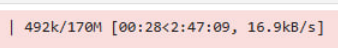
### - Полносвязная сеть (глубокая)
### - CNN с Residual блоками
### - CNN с регуляризацией и Residual блоками

In [ ]:
# Сравните производительность на CIFAR-10:
# - Полносвязная сеть (глубокая)
class DeepFCN(nn.Module):
    def __init__(self, in_channel=1, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(in_channel, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.features(x)
        return self.classifier(x)

        
# - CNN с Residual блоками
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNetLike(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2)
        self.layer3 = self._make_layer(128, 256, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, blocks):
        layers = [ResidualBlock(in_channels, out_channels, stride=1)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)
 


In [512]:
deepFCN_model = DeepFCN(in_channel=28*28)
resnetCNN_model = ResNetLike()

# Обучение моделей
deppFCN_metrics = train_model(deepFCN_model, test_loader=mnist_test, train_loader=mnist_train)
resnetCNN_metrics = train_model(resnetCNN_model, test_loader=mnist_test, train_loader=mnist_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [36:39<00:00, 219.91s/it]


In [519]:
# Сохраним метрики и модель
torch.save(deppFCN_metrics, 'laba4/deppFCN_metrics.pt')
torch.save(resnetCNN_metrics, 'laba4/resnetCNN_metrics.pt')
torch.save(resnetCNN_metrics, 'laba4/resnetCNN_model.pt')


ResnetCNN


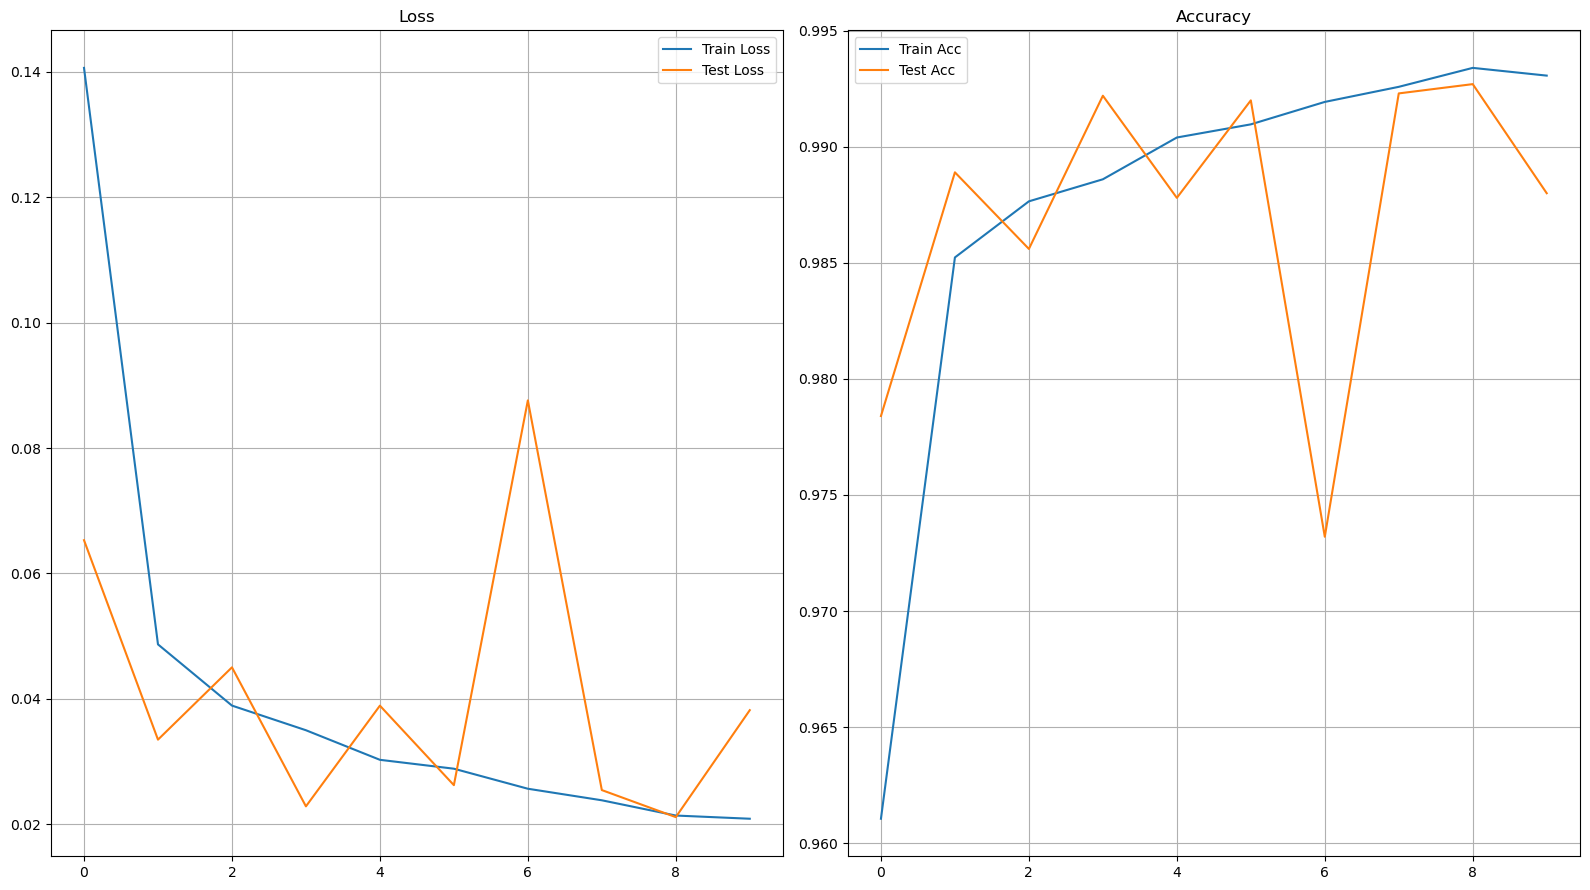

DeepFCN


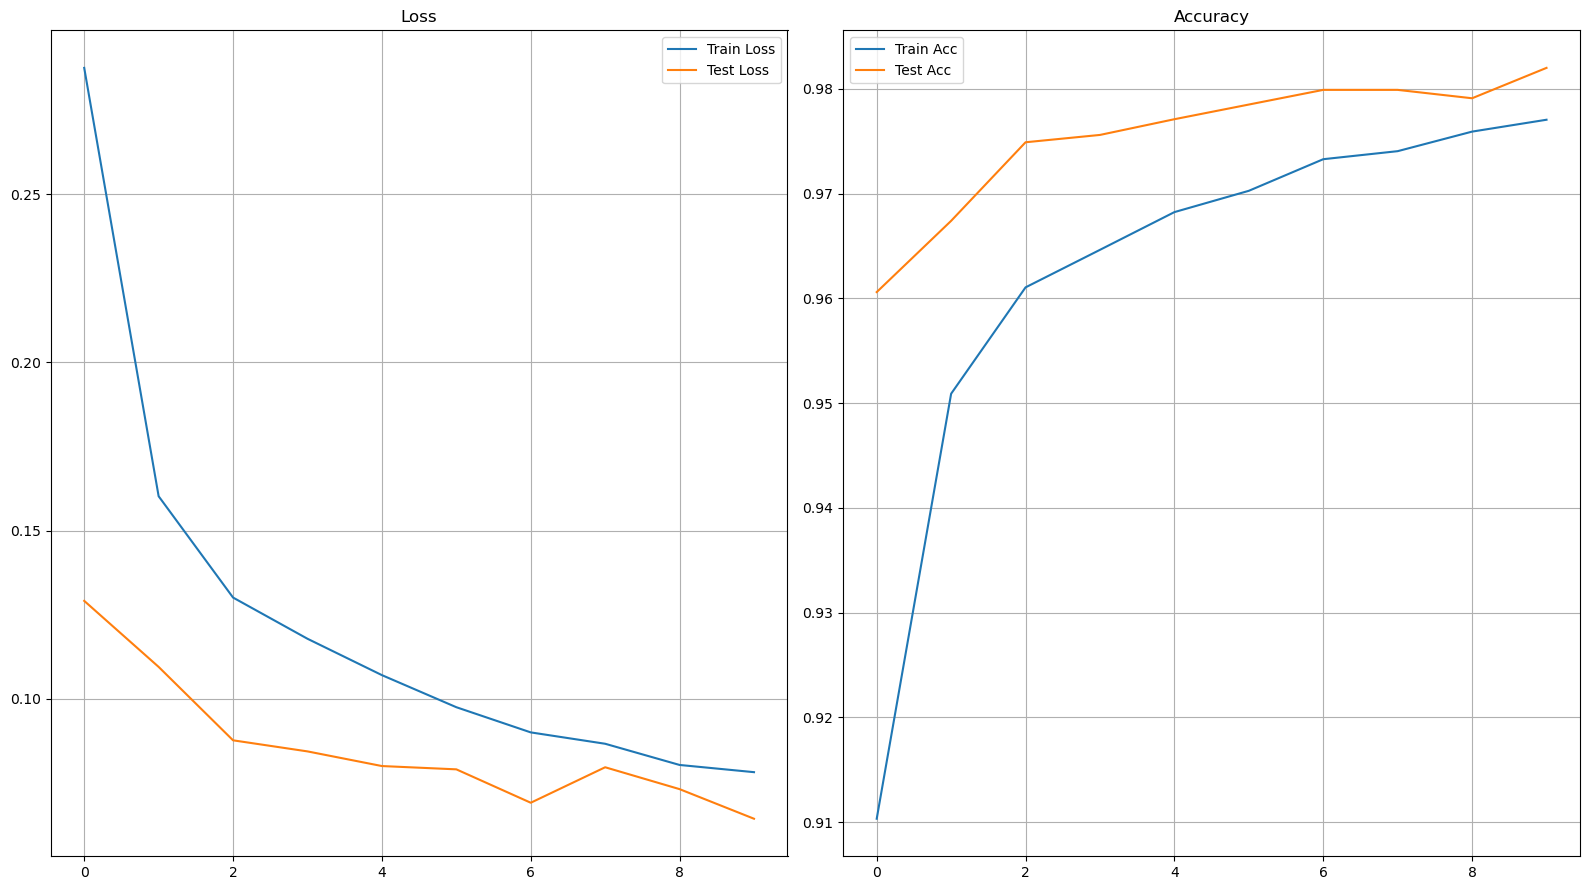

In [523]:
print('ResnetCNN')
plot_training_history(resnetCNN_metrics)
print('DeepFCN')
plot_training_history(deppFCN_metrics)

## Для каждого варианта:
- Обучите модель с одинаковыми гиперпараметрами
  > DONE
 - Сравните точность и время обучения
  > График у resnetCNN гораздо ломанный (скорее всего из-за отсутсвия Dropout), но все равно показывает лучший результат.
  >
  > Но затраченное время (модель обучалась **37 минут** против *3:30 у FCN*) и ресурсы на обучение resnetCNN, возможно, не стоит +1% к точности
 -  Проанализируйте переобучение
   > 
 - Визуализируйте confusion matrix
   > Визуализировал
 - Исследуйте градиенты (gradient flow)
   > Вывел график с градиентами разных слоев (смещение и т.д)

### Визуализация confusion matrix

In [541]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, title = '', device='cuda:0'):
    model.eval()
    all_preds = []
    all_targets = []
    model = model.to(device)
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix {title}')
    plt.show()


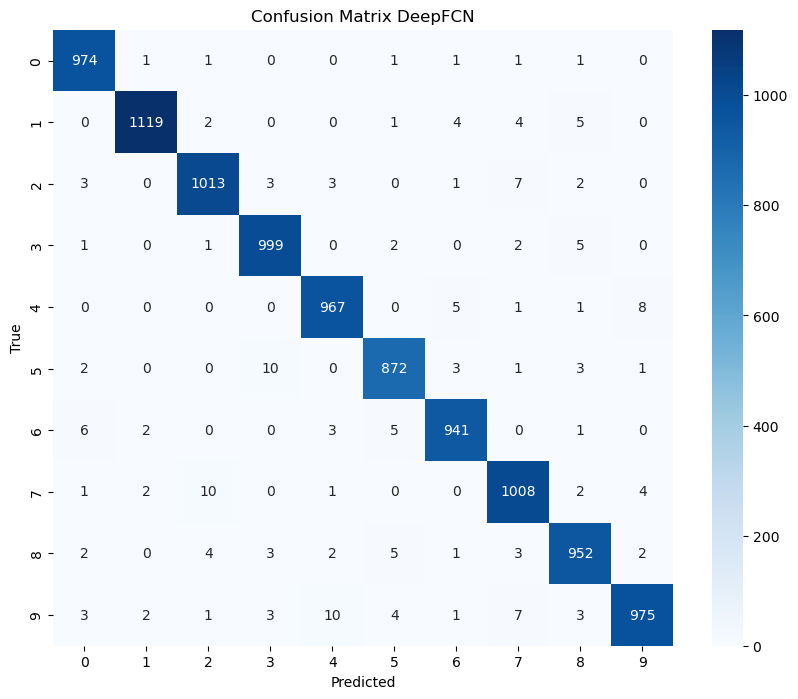

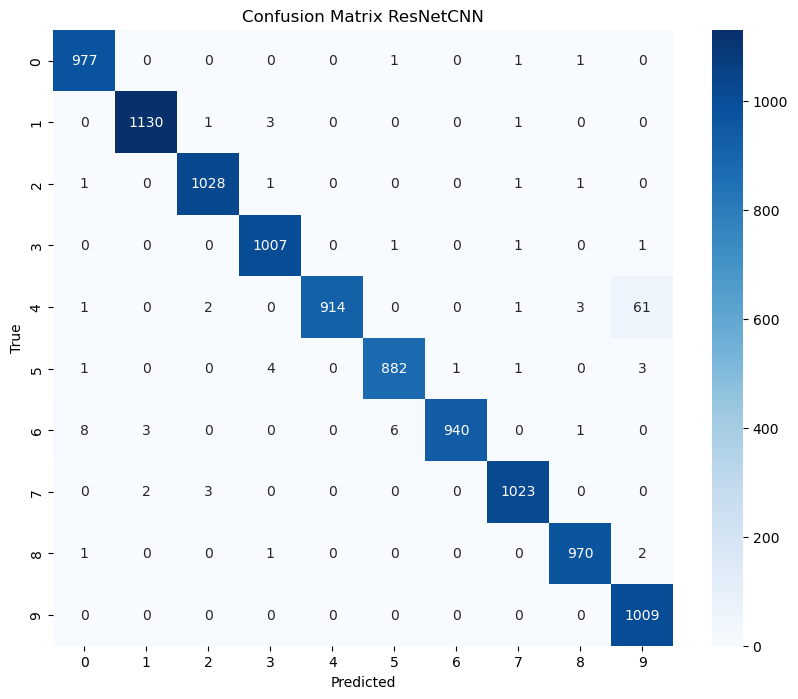

In [545]:
plot_confusion_matrix(deepFCN_model, mnist_test, 'DeepFCN')
plot_confusion_matrix(resnetCNN_model, mnist_test, 'ResNetCNN')

### Gradient Flow 

In [575]:
def plot_gradient_flow(model, data_loader,model_name='', device='cuda:0'):
    """Улучшенная визуализация градиентов с диагностикой"""
    model.train()
    model.to(device)
    
    # Сбрасываем градиенты
    for param in model.parameters():
        if param.grad is not None:
            param.grad.zero_()
    
    # Получаем один батч данных
    try:
        inputs, targets = next(iter(data_loader))
    except StopIteration:
        data_loader = iter(data_loader)
        inputs, targets = next(data_loader)
    
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward + backward pass
    outputs = model(inputs)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    
    # Собираем данные для графика
    grad_data = []
    layers = []
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            grad_mean = param.grad.abs().mean().item()
            grad_data.append(grad_mean)
            layers.append(name)
            print(f"Слой {name}: grad_mean = {grad_mean:.2e}")  # Диагностика
    
    # Визуализация
    plt.figure(figsize=(12, 12))
    plt.barh(layers, grad_data)
    plt.xscale('log')  # Логарифмическая шкала для лучшего отображения
    plt.xlabel("Среднее значение градиента (log scale)")
    plt.ylabel("Слои")
    plt.title(f"Анализ потока градиентов модели {model_name}")
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    plt.show()



Слой features.0.weight: grad_mean = 3.81e-05
Слой features.0.bias: grad_mean = 6.37e-05
Слой features.3.weight: grad_mean = 1.75e-05
Слой features.3.bias: grad_mean = 5.78e-05
Слой features.6.weight: grad_mean = 3.36e-05
Слой features.6.bias: grad_mean = 5.20e-05
Слой classifier.weight: grad_mean = 1.16e-03
Слой classifier.bias: grad_mean = 2.15e-03


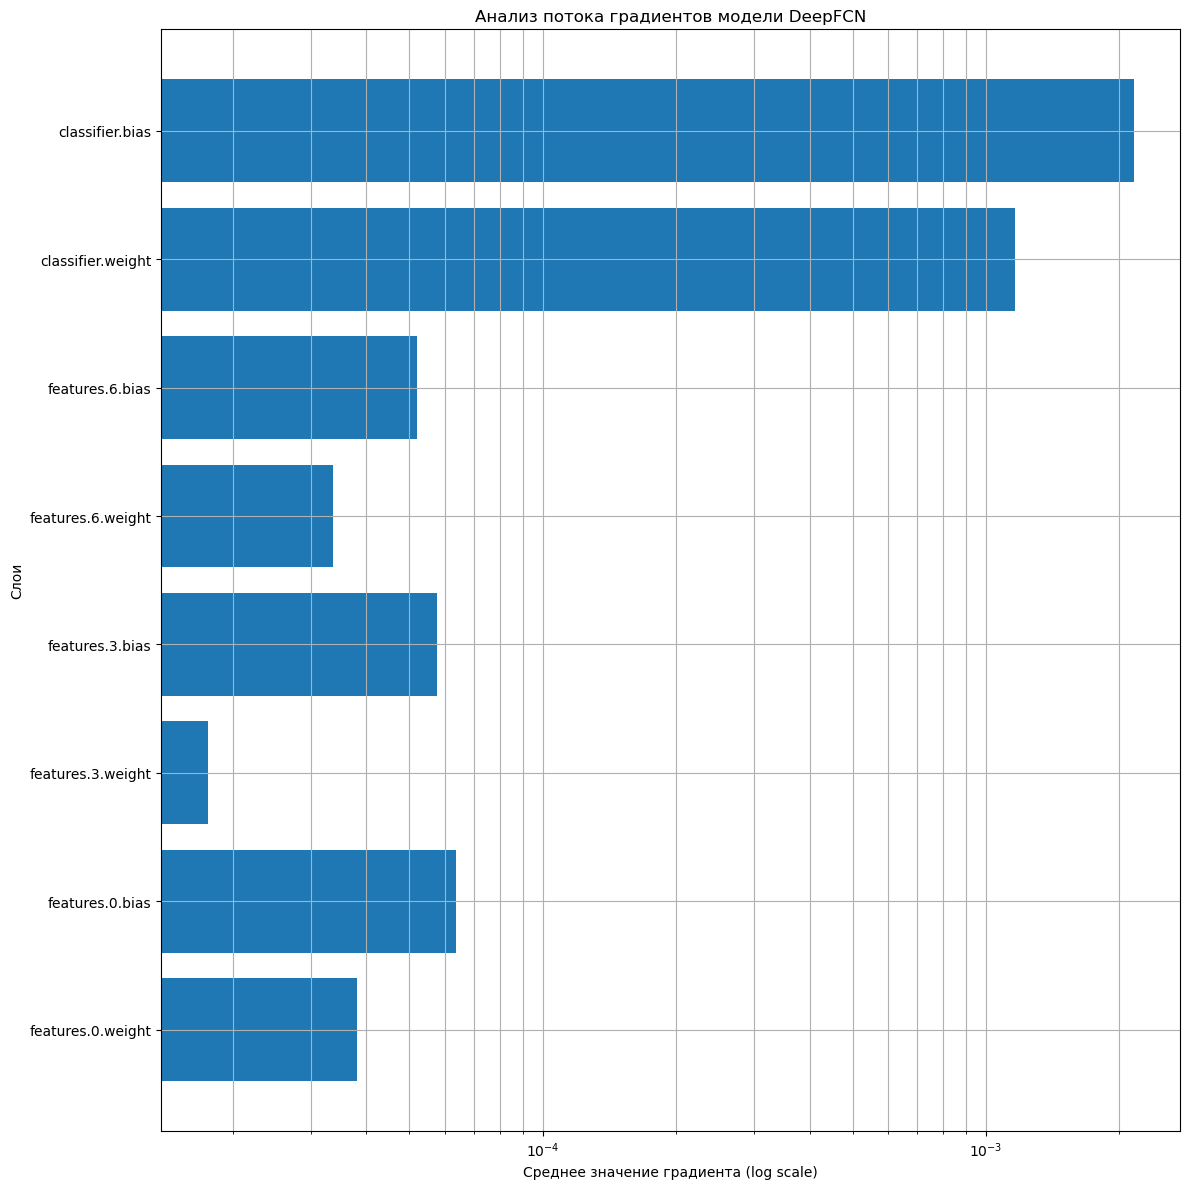

Слой conv1.weight: grad_mean = 4.50e-03
Слой bn1.weight: grad_mean = 1.94e-03
Слой bn1.bias: grad_mean = 1.27e-03
Слой layer1.0.conv1.weight: grad_mean = 1.73e-04
Слой layer1.0.bn1.weight: grad_mean = 1.30e-03
Слой layer1.0.bn1.bias: grad_mean = 9.59e-04
Слой layer1.0.conv2.weight: grad_mean = 2.28e-04
Слой layer1.0.bn2.weight: grad_mean = 1.71e-03
Слой layer1.0.bn2.bias: grad_mean = 1.02e-03
Слой layer1.1.conv1.weight: grad_mean = 1.90e-04
Слой layer1.1.bn1.weight: grad_mean = 1.03e-03
Слой layer1.1.bn1.bias: grad_mean = 6.82e-04
Слой layer1.1.conv2.weight: grad_mean = 2.00e-04
Слой layer1.1.bn2.weight: grad_mean = 1.12e-03
Слой layer1.1.bn2.bias: grad_mean = 6.18e-04
Слой layer2.0.conv1.weight: grad_mean = 1.07e-04
Слой layer2.0.bn1.weight: grad_mean = 6.05e-04
Слой layer2.0.bn1.bias: grad_mean = 3.82e-04
Слой layer2.0.conv2.weight: grad_mean = 5.37e-05
Слой layer2.0.bn2.weight: grad_mean = 7.66e-04
Слой layer2.0.bn2.bias: grad_mean = 4.75e-04
Слой layer2.0.shortcut.0.weight: grad_me

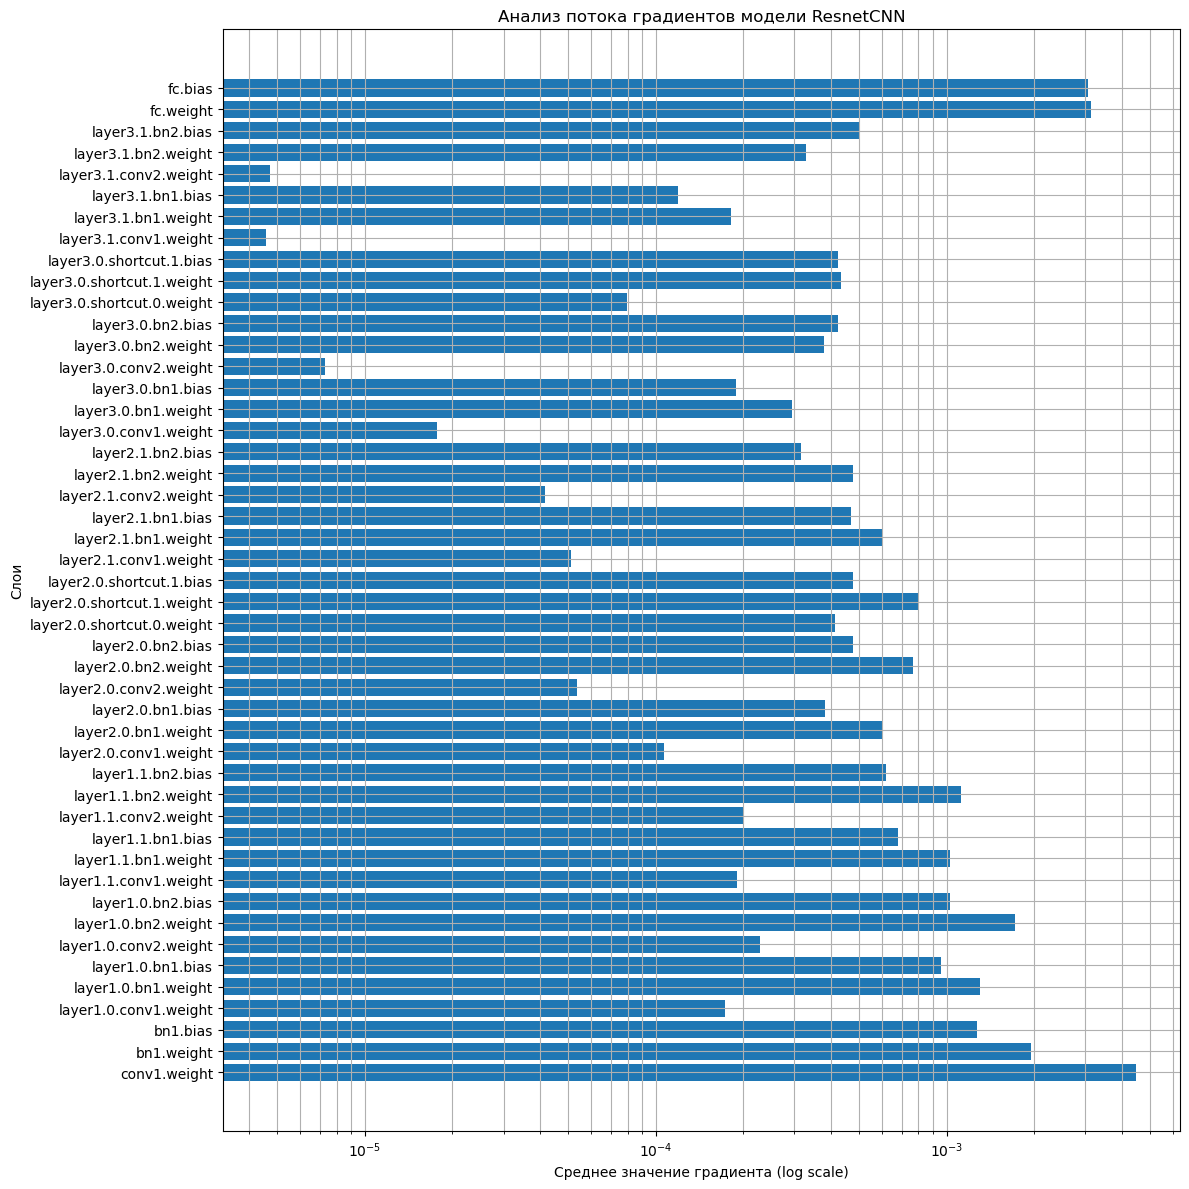

In [577]:
plot_gradient_flow(deepFCN_model, mnist_test, 'DeepFCN')
plot_gradient_flow(resnetCNN_model, mnist_test, 'ResnetCNN')

